In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
import pandas as pd
import numpy as np

import PIL

from PIL import *
import cv2
import random
import copy
from scipy.ndimage import convolve
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

In [5]:
# Dataset Link (https://www.kaggle.com/code/ajayuser/emotion-detection-icml-face-data)
ExpressionDataset = pd.read_csv('icml_face_data.csv')
ExpressionDataset

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [6]:
#Convert string to array
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [7]:
#Increase size of images
def resize(x):
  img = x.reshape(48,48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [8]:
ExpressionDataset[' pixels']=ExpressionDataset[' pixels'].apply(lambda x:string2array(x))
ExpressionDataset[' pixels'] =ExpressionDataset[' pixels'].apply(lambda x: resize(x))
ExpressionDataset.shape

(35887, 3)

In [9]:
#Set up emotions
label_emotion = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}
emotionarray = [0,1,2,3,4,5,6]

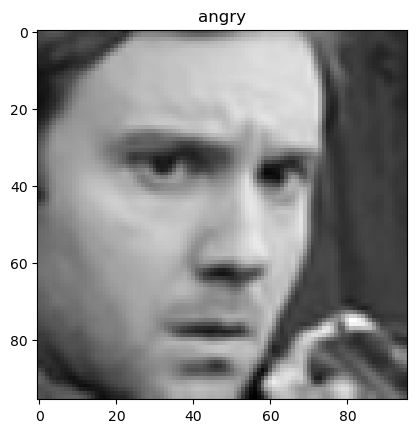

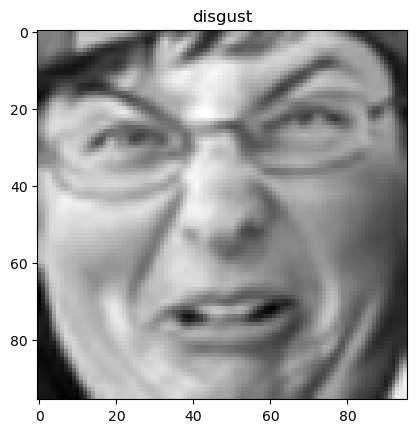

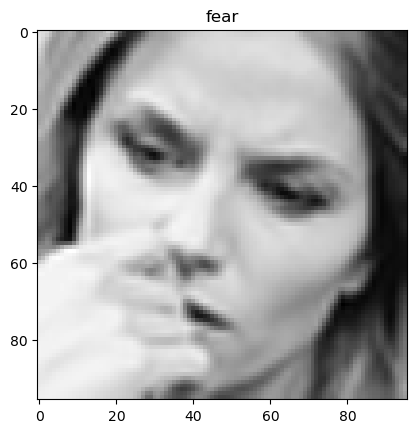

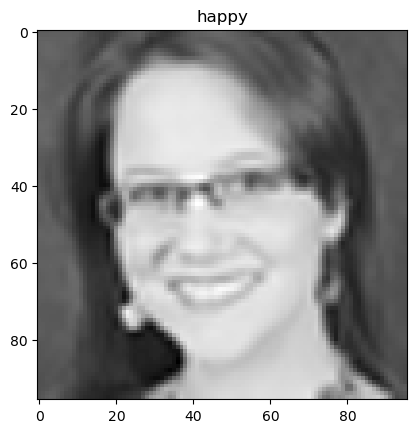

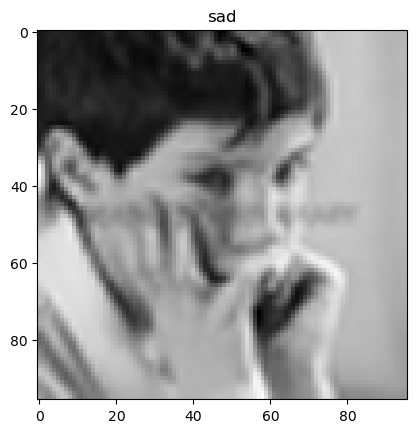

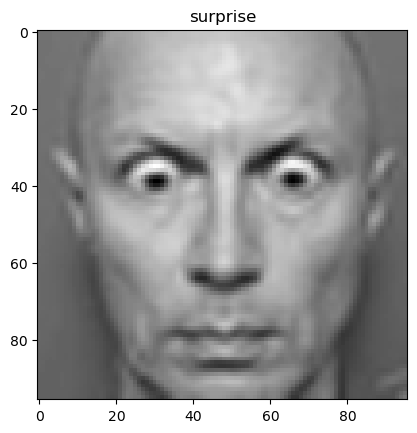

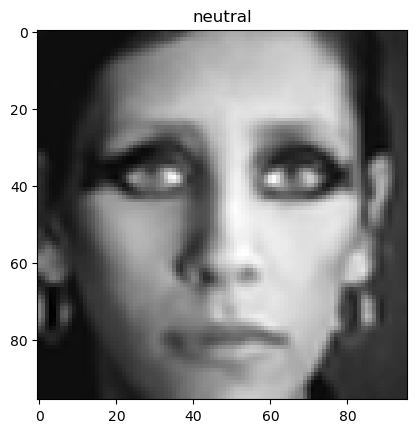

In [10]:
for i in emotionarray:
  data = ExpressionDataset[ExpressionDataset['emotion'] == i][:1]
  img = data[' pixels'].item()
  plt.figure()
  plt.title(label_emotion[i])
  plt.imshow(img, cmap = 'gray')

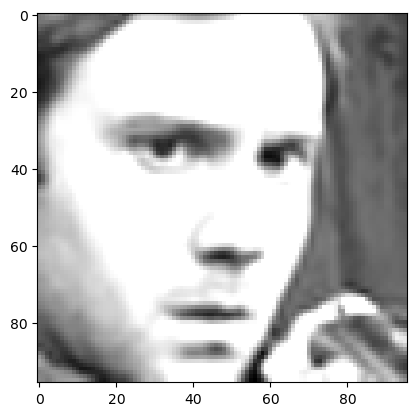

In [11]:
#augmentation 1 - brighten (in overexposed environments)
brightness_ExpressionDataset=copy.copy(ExpressionDataset)
brightness_ExpressionDataset[' pixels']=brightness_ExpressionDataset[' pixels'].apply(lambda x:np.clip(random.uniform(1.7,2.2)*x,0.0,255))
plt.imshow(brightness_ExpressionDataset[' pixels'][0],cmap='gray')
plt.imshow(brightness_ExpressionDataset[' pixels'][0], cmap='gray')

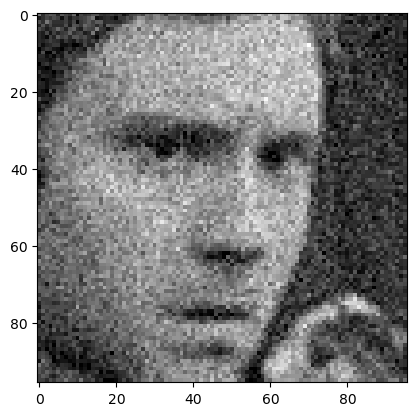

In [12]:
#augmentation 2 - darken + gaussiannoise (In dark environments)
def add_gaussian_noise_and_darken(image):
    darken_factor = np.random.uniform(0.08, 0.2)
    darkened_image = np.clip(image * darken_factor, 0, 255)
    row, col = darkened_image.shape
    mean = 0
    var = 3
    sigma = var**1
    gaussian_noise = np.random.normal(mean, sigma, (row, col))
    noisy_image = np.clip(darkened_image + gaussian_noise, 0, 255)
    return noisy_image.astype('uint8')
gaunoise_ExpressionDataset = copy.copy(ExpressionDataset)
gaunoise_ExpressionDataset[' pixels'] = gaunoise_ExpressionDataset[' pixels'].apply(add_gaussian_noise_and_darken)
plt.imshow(gaunoise_ExpressionDataset[' pixels'][0], cmap='gray')

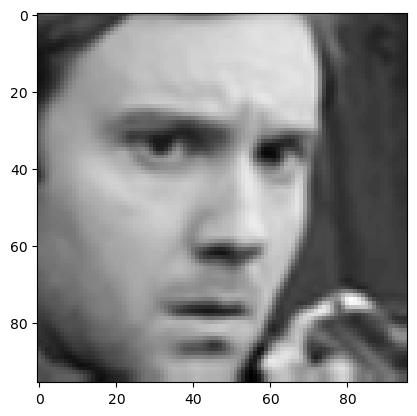

In [13]:
#augmentation 3 - motionblur (for moving subjects)
def apply_motion_blur(image, size, angle):
    kernel = np.zeros((size, size))
    kernel[int((size-1)/2), :] = np.ones(size)
    kernel = kernel / size
    rotation_matrix = cv2.getRotationMatrix2D((size / 2 - 0.5, size / 2 - 0.5), angle, 1)
    kernel = cv2.warpAffine(kernel, rotation_matrix, (size, size))
    blurred_image = convolve(image.astype(np.float32), kernel.astype(np.float32))
    blurred_image =np.clip(blurred_image, 0, 255).astype('uint8')
    return blurred_image
def add_motion_blur(image):
    random_size = np.random.randint(2, 11)
    random_angle = np.random.randint(2, 160) * 10
    return apply_motion_blur(image, size=random_size, angle=random_angle)
mb_ExpressionDataset = copy.copy(ExpressionDataset)
mb_ExpressionDataset[' pixels'] = mb_ExpressionDataset[' pixels'].apply(add_motion_blur)
plt.imshow(mb_ExpressionDataset[' pixels'][0], cmap='gray')

In [14]:
#Add all augmented datasets tgt (not done for now because not enough ram in the free version)
#TrainingDataset = pd.concat([ExpressionDataset],ignore_index=True)
TrainingDataset = pd.concat([ExpressionDataset,brightness_ExpressionDataset,gaunoise_ExpressionDataset,mb_ExpressionDataset],ignore_index=True)

TrainingDataset

,emotion,Usage,pixels
0,0,Training,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,Training,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,Training,"[[232.82553, 229.81886, 225.59953, 200.68909, ..."
3,4,Training,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
4,6,Training,"[[4.771652, 3.3384705, 0.9779358, -0.45524597,..."
...,...,...,...
143543,6,PrivateTest,"[[44, 41, 35, 27, 21, 18, 20, 21, 23, 25, 28, ..."
143544,3,PrivateTest,"[[178, 176, 174, 173, 173, 174, 177, 180, 183,..."
143545,0,PrivateTest,"[[13, 13, 13, 12, 13, 15, 18, 21, 21, 19, 16, ..."
143546,3,PrivateTest,"[[30, 30, 29, 29, 28, 29, 29, 30, 31, 31, 32, ..."


In [15]:
TrainingDataset.shape

(143548, 3)

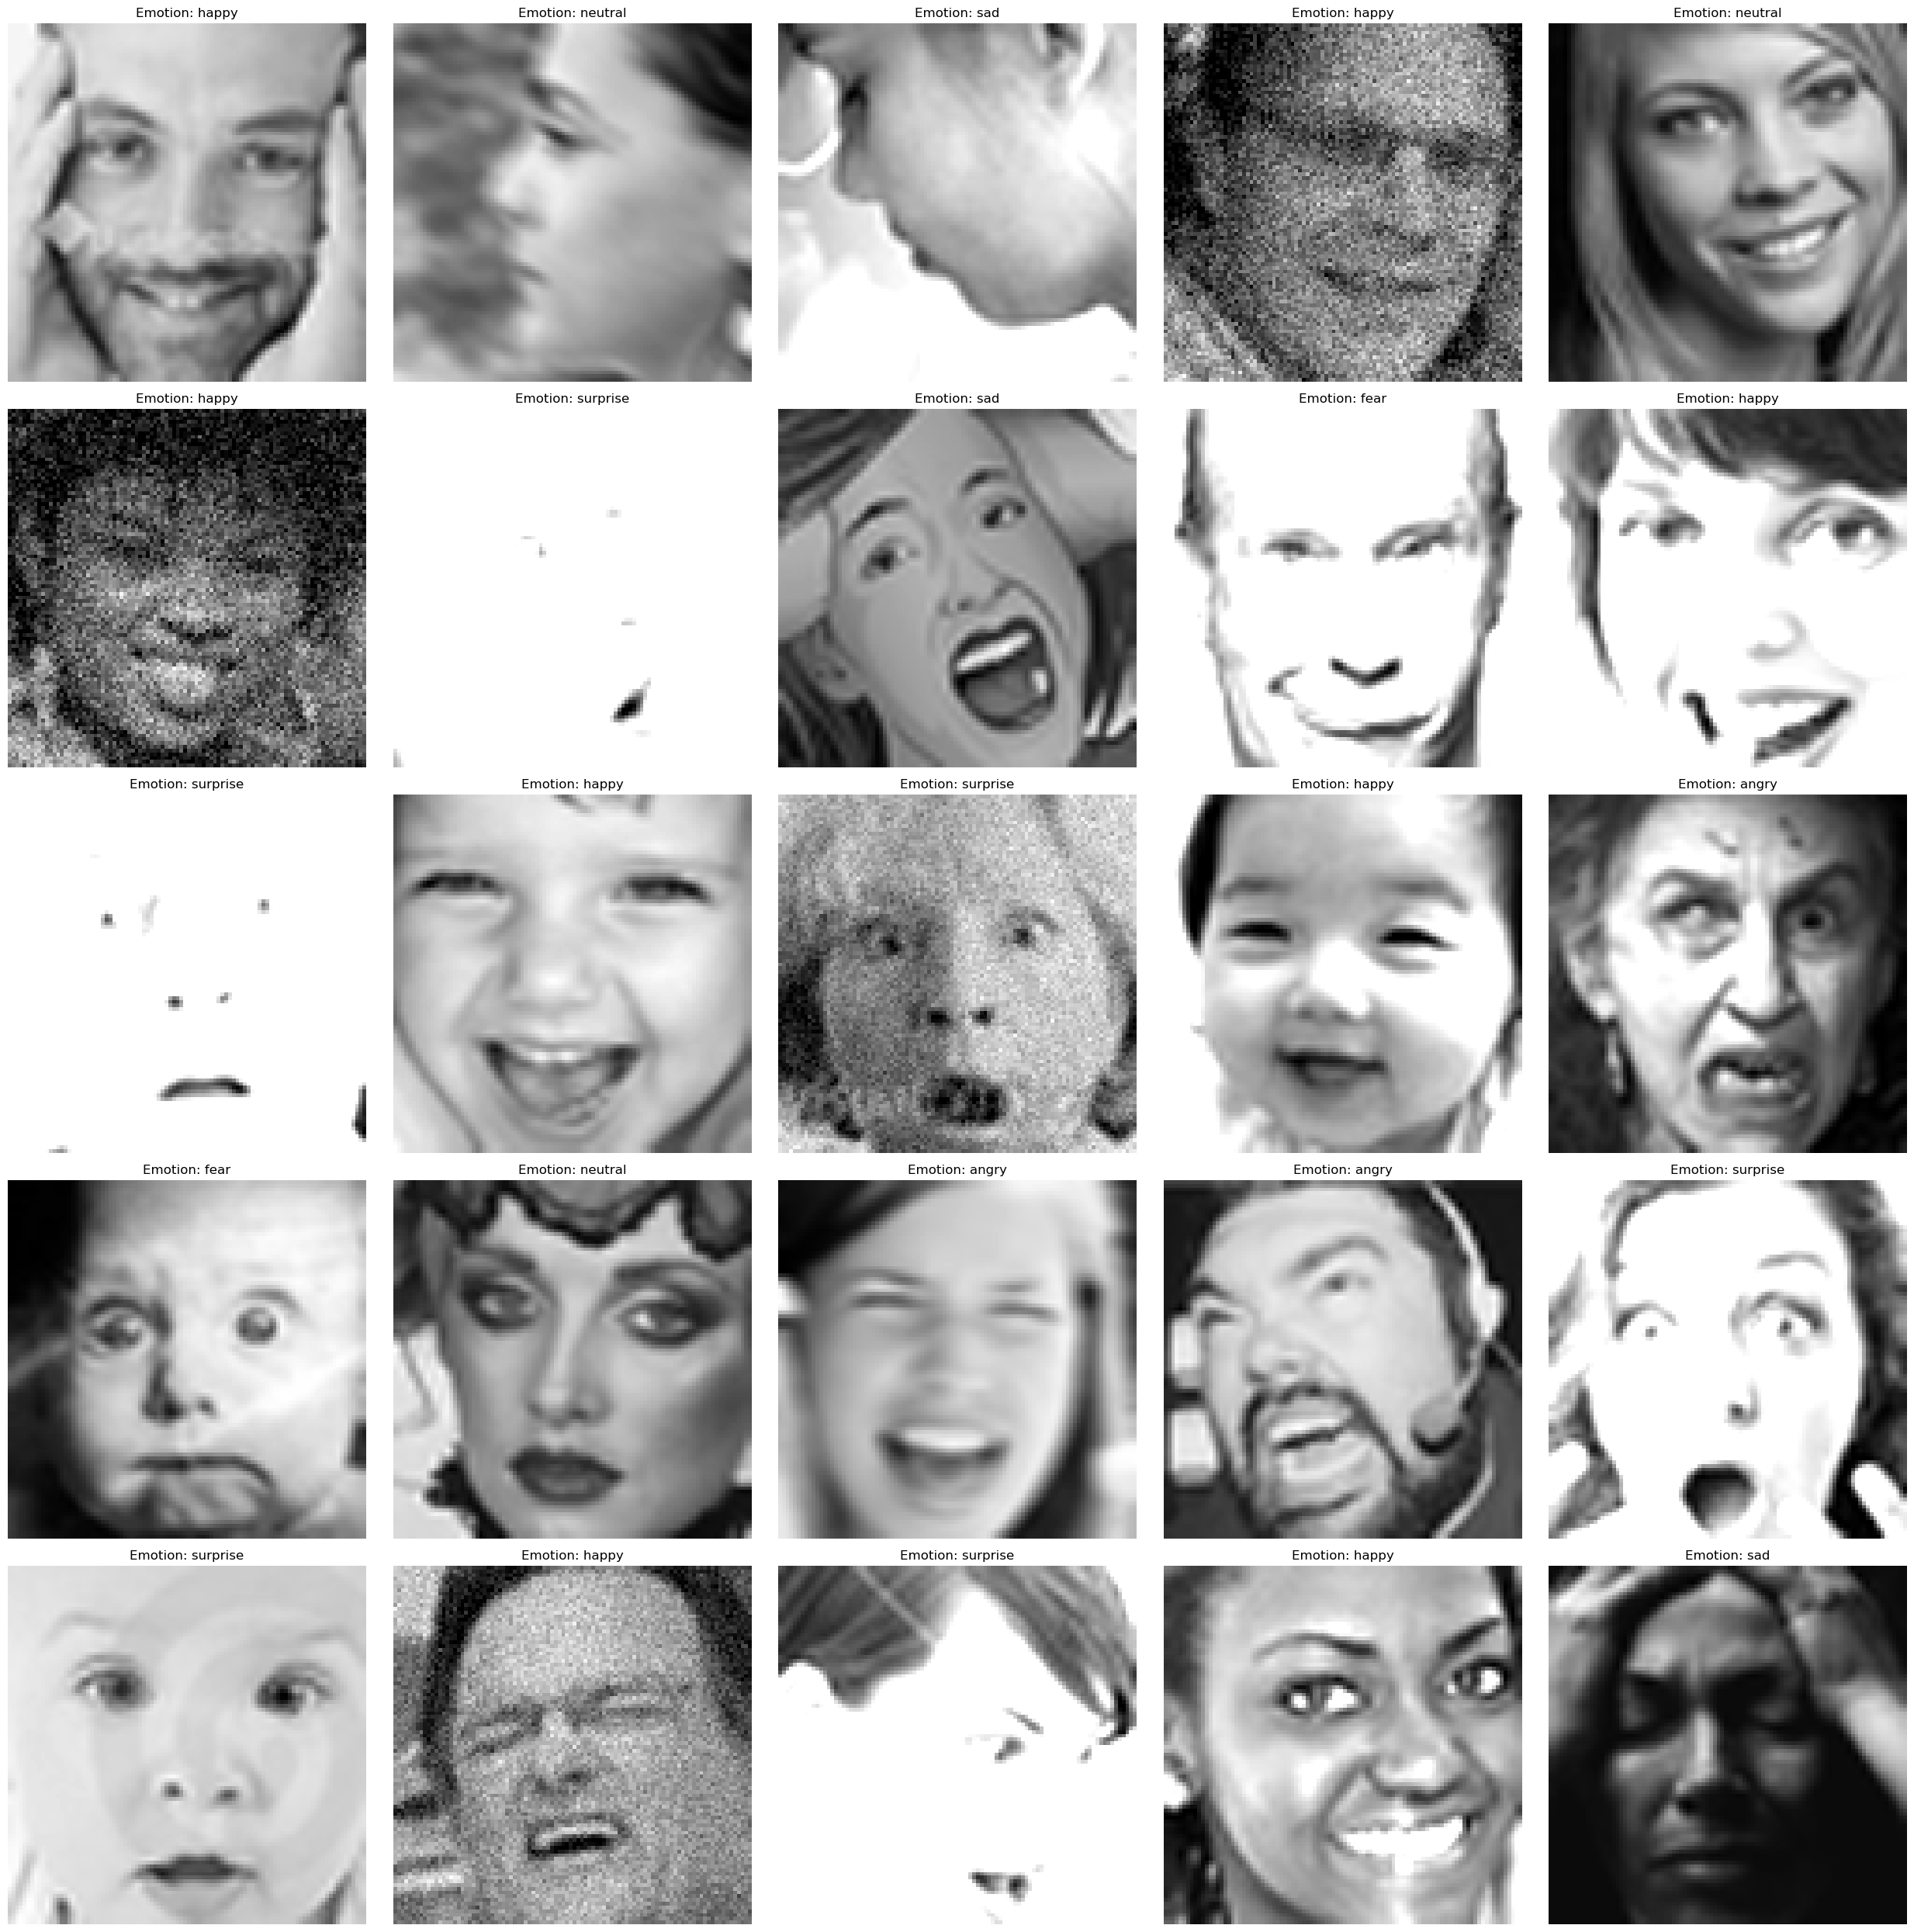

In [16]:
#Training Data Sanity Check

grid = plt.figure(figsize=(25, 25))

for i in range(25):
    axes = grid.add_subplot(5, 5, i+1)
    k = random.randint(0, len(TrainingDataset) - 1)
    image_data = (TrainingDataset[' pixels'].iloc[k])
    image_data = image_data / 255.0
    axes.imshow(image_data, cmap='gray')
    emotion_label = TrainingDataset['emotion'].iloc[k]
    emotion_name = label_emotion.get(emotion_label, 'Unknown')
    axes.set_title(f'Emotion: {emotion_name}')
    axes.axis('off')

plt.tight_layout()
plt.show()

In [17]:
#Prepare data for training

pixels=TrainingDataset[' pixels']
emotion=to_categorical(TrainingDataset['emotion'])

pixels=np.stack(pixels, axis=0)
pixels=pixels.reshape(143548,96,96,1)

pixels_train, pixels_test, emotion_train, emotion_test = train_test_split(pixels,emotion,test_size=0.2,shuffle=True)
pixels_train, pixels_val, emotion_train, emotion_val = train_test_split(pixels_train, emotion_train, test_size=0.3, shuffle=True)

pixels_train=pixels_train/255
pixels_val=pixels_val/255
pixels_test=pixels_test/255

print(pixels_train.shape, pixels_val.shape, pixels_test.shape)


(80386, 96, 96, 1) (34452, 96, 96, 1) (28710, 96, 96, 1)


In [18]:
#Augmenting All Images Round 2
augmentround2=ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model

def identity_block(X, filters, stage, block):
    f1, f2, f3 = filters

    X_copy = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_{block}_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_{block}_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_identity_{block}_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_{block}_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_identity_{block}_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_identity_{block}_c')(X)

    # Merge Short Path & Main Path
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, filters, stage, block, stride=2):
    f1, f2, f3 = filters

    X_copy = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(stride, stride), name=f'res_{stage}_convolutional_{block}_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_convolutional_{block}_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=f'res_{stage}_convolutional_{block}_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_convolutional_{block}_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, (1, 1), strides=(1, 1), name=f'res_{stage}_convolutional_{block}_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'bn_{stage}_convolutional_{block}_c')(X)

    # Short path
    X_copy = Conv2D(f3, (1, 1), strides=(stride, stride), name=f'res_{stage}_convolutional_{block}_copy', kernel_initializer=glorot_uniform(seed=0))(X_copy)
    X_copy = BatchNormalization(axis=3, name=f'bn_{stage}_convolutional_{block}_copy')(X_copy)

    # Merge Short Path & Main Path
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(96, 96, 1), classes=6):
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPool2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, [64, 64, 256], stage=2, block='a', stride=1)
    X = identity_block(X, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, [128, 128, 512], stage=3, block='a', stride=2)
    X = identity_block(X, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, [256, 256, 1024], stage=4, block='a', stride=2)
    X = identity_block(X, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, [512, 512, 2048], stage=5, block='a', stride=2)
    X = identity_block(X, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Create ResNet50 model for (96, 96, 1) input shape
EmotionAI = ResNet50(input_shape=(96, 96, 1), classes=7)

# Compile the model
EmotionAI.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
#Optimizer setup
EmotionAI.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
earlystop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
checkpoint = ModelCheckpoint(filepath = "EmotionAIweight.hdf5", verbose = 1, save_best_only=True)

In [21]:
# Not running - done training
# history = EmotionAI.fit(augmentround2.flow(pixels_train, emotion_train, batch_size=32),
# validation_data=(pixels_val, emotion_val), steps_per_epoch=len(pixels_train) // 32,
# epochs= 30, callbacks=[checkpoint, earlystop])

# Load model instead
EmotionAI = load_model('EmotionAIModel2')


Epoch 1/30
2512/2512 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.7842
Epoch 1: val_loss improved from inf to 0.59801, saving model to EmotionAIweight.hdf5
2512/2512 [==============================] - 236s 92ms/step - loss: 0.5903 - accuracy: 0.7842 - val_loss: 0.5980 - val_accuracy: 0.7942
Epoch 2/30
2512/2512 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7962
Epoch 2: val_loss improved from 0.59801 to 0.58846, saving model to EmotionAIweight.hdf5
2512/2512 [==============================] - 229s 91ms/step - loss: 0.5516 - accuracy: 0.7962 - val_loss: 0.5885 - val_accuracy: 0.7869
Epoch 3/30
2512/2512 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.8061
Epoch 3: val_loss improved from 0.58846 to 0.50941, saving model to EmotionAIweight.hdf5
2512/2512 [==============================] - 230s 91ms/step - loss: 0.5265 - accuracy: 0.8061 - val_loss: 0.5094 - val_accuracy: 0.8205
Epoch 4/30
2512/2512 [=============

In [22]:
#Save model
# EmotionAI.save('EmotionAIModel2', save_format='tf')

INFO:tensorflow:Assets written to: EmotionAIModel2\assets


INFO:tensorflow:Assets written to: EmotionAIModel2\assets


898/898 [==============================] - 25s 28ms/step - loss: 0.4499 - accuracy: 0.8589
Test Loss: 0.44994398951530457
Test Accuracy: 0.8588644862174988


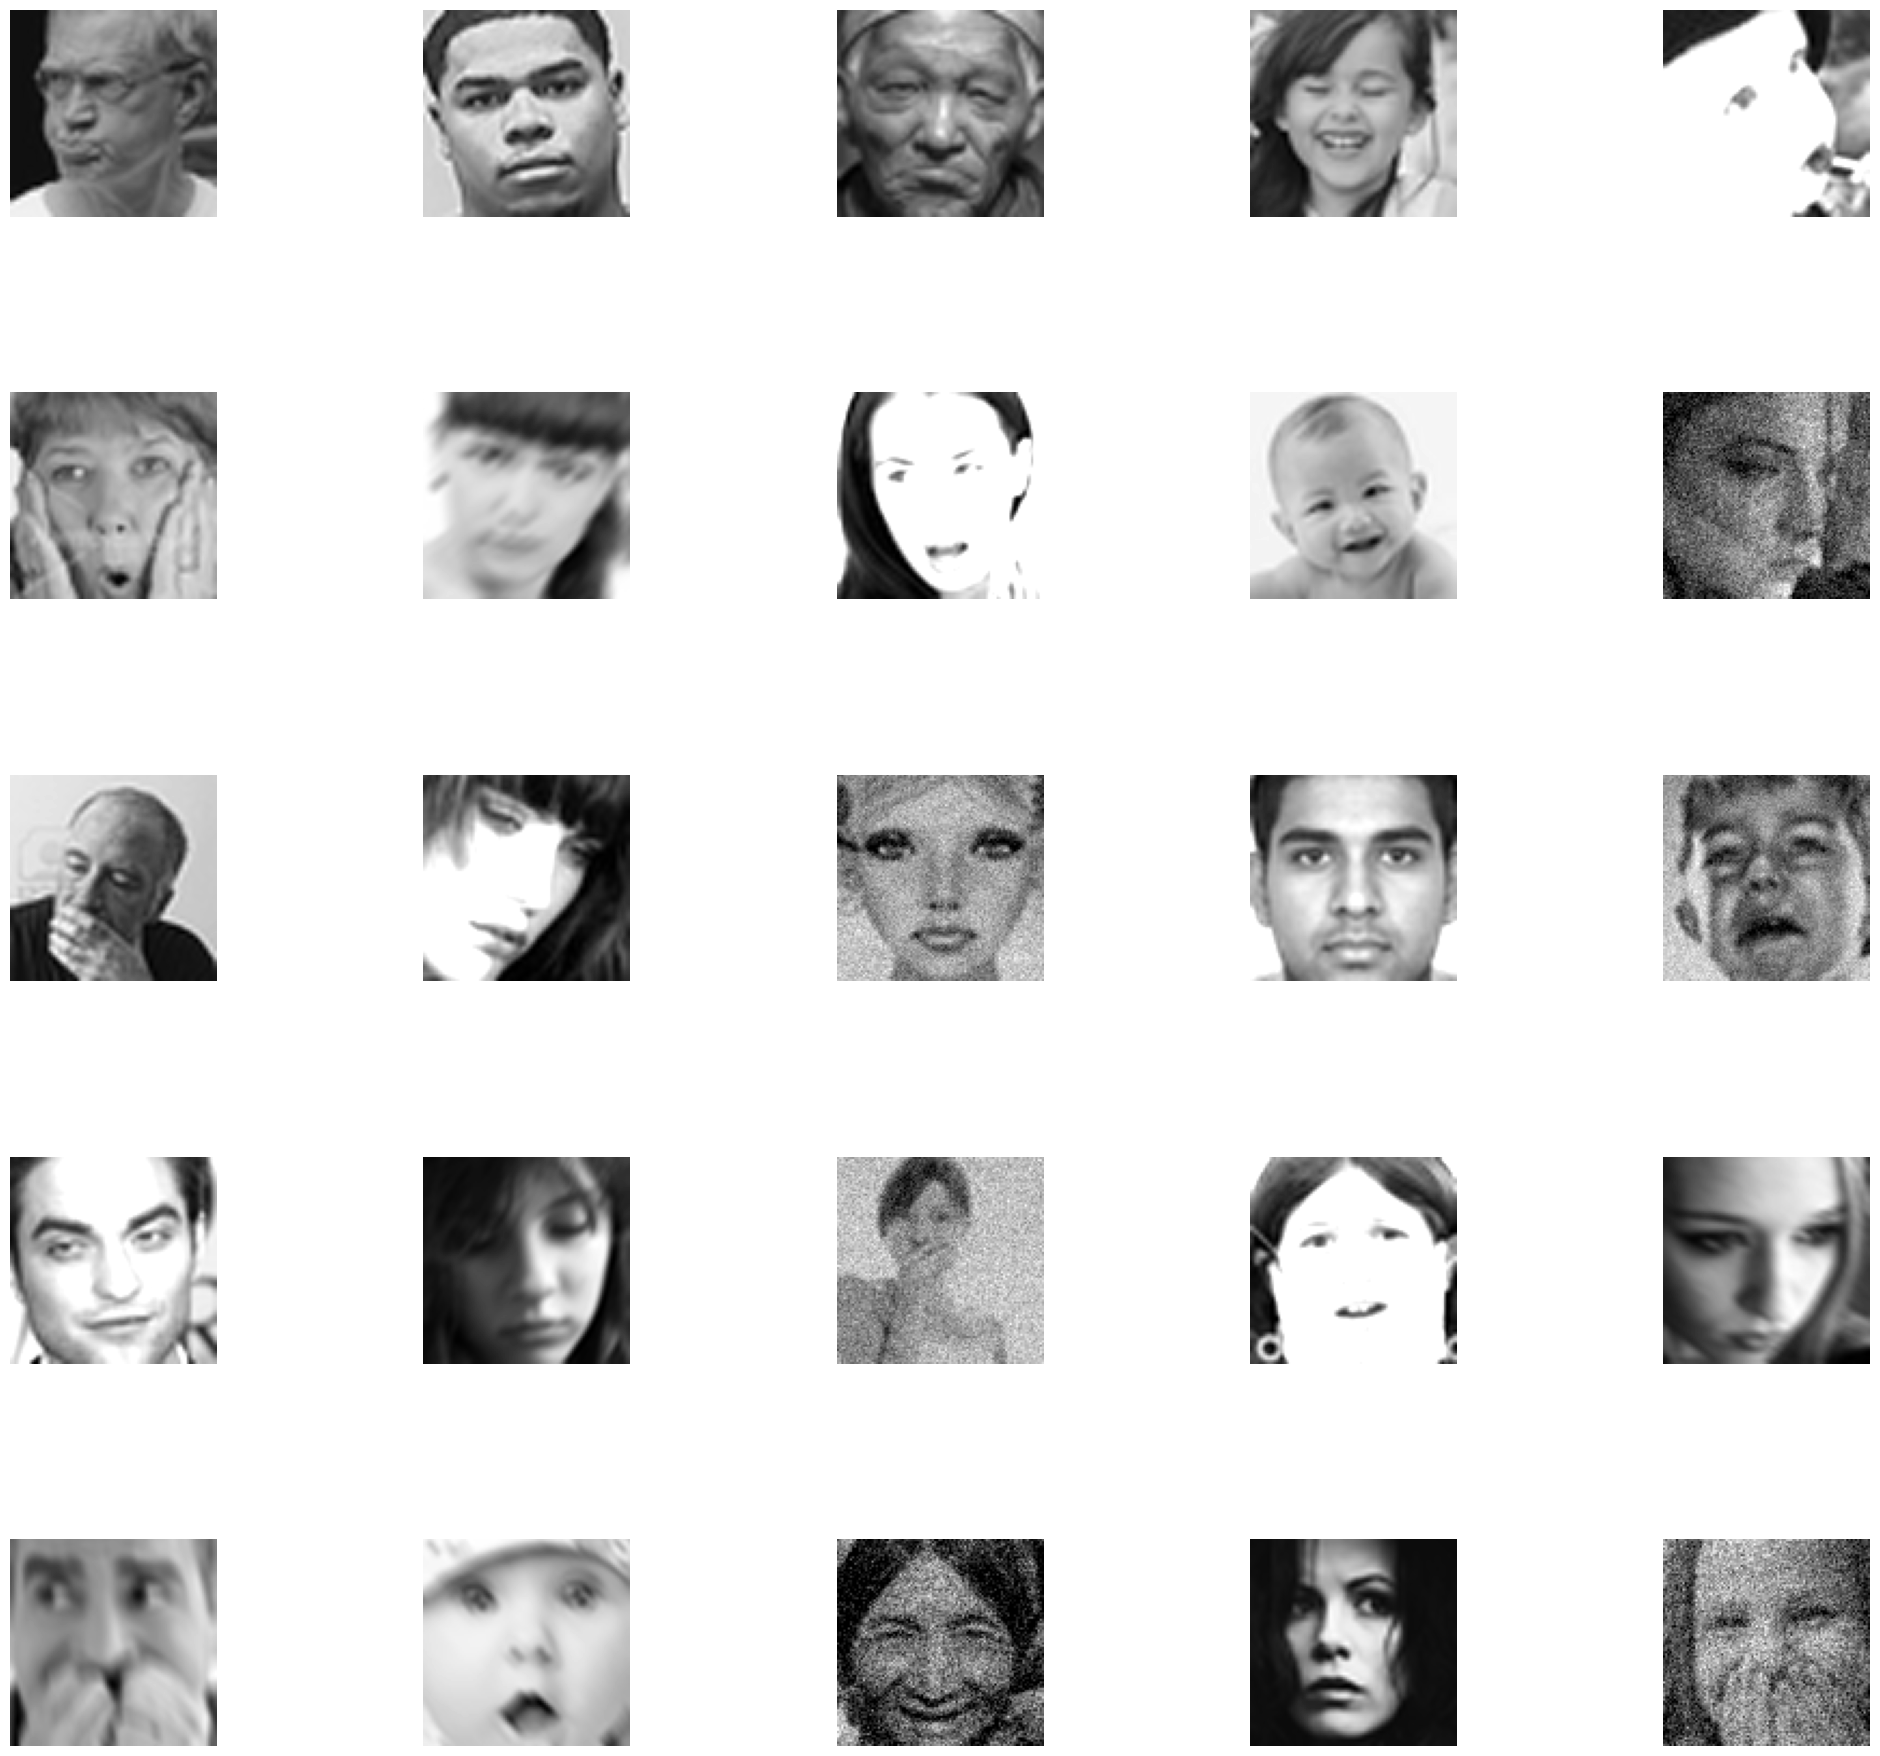

In [23]:
#Evaluate AI Performance
test_loss, test_accuracy = EmotionAI.evaluate(pixels_test, emotion_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

fig, axes = plt.subplots(5, 5, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, 25):
  axes[i].imshow(pixels_test[i].reshape(96,96), cmap = 'gray')
  #axes[i].set_title('Prediction = {}\n True = {}'.format(label_emotion[predicted_classes[i]], label_emotion[emotion_true[i]]))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

# Demo - 7 Test Images

In [20]:
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model
from PIL import Image

image_array = ['TestImages/sad2.png', 'TestImages/sad4.png', 'TestImages/angry6.png', 'TestImages/happy2.png', 'TestImages/happy.png', 'TestImages/angry.png', 'TestImages/sad.png']
sum = 0

def EmotionAI(image_path, sum):
    model = load_model('EmotionAIModel2')

    # Load the image using PIL
    img = Image.open(image_path)
    img = img.convert('L')

    img = img.resize((96,96))
    img_array = np.array(img)
    img_array = img_array/255
    img_array = np.expand_dims(img_array, axis=0)
    img_array=img_array.reshape(1,96,96,1)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    print("Predicted Class Index:", predicted_class_index)


    label_emotion = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}
    print("Class: ", label_emotion[predicted_class_index])

    probabilities = tf.nn.softmax(predictions).numpy()
    print()

    if(predicted_class_index in [0,2,4]):
        return probabilities[0,predicted_class_index]
    else:
        return 0

# Iterate through every images
for i in range(len(image_array)):
    sum += EmotionAI(image_array[i], sum)

EmotionAIOutput = sum / len(image_array)
%store EmotionAIOutput



1/1 [==============================] - 1s 797ms/step
Predicted Class Index: 4
Class:  sad

1/1 [==============================] - 1s 797ms/step
Predicted Class Index: 4
Class:  sad

1/1 [==============================] - 1s 817ms/step
Predicted Class Index: 6
Class:  neutral

1/1 [==============================] - 1s 832ms/step
Predicted Class Index: 3
Class:  happy

1/1 [==============================] - 1s 837ms/step
Predicted Class Index: 4
Class:  sad

1/1 [==============================] - 1s 813ms/step
Predicted Class Index: 6
Class:  neutral

1/1 [==============================] - 1s 820ms/step
Predicted Class Index: 6
Class:  neutral

Stored 'EmotionAIOutput' (float64)
